In [2]:
import numpy as np          
from matplotlib import pyplot as plt

s0 = np.random.normal(100,1,200)
s1 = [50,61,41,62,35,58,66,50,51,51,52,80,130,150,170,
    200,200,201,202,210,200,200,400,500,600,600,400,350,
    200,200,201,202,210,200,200,201,202,210,200,200,201,202,201,202,210,200,200,201,202] 

def readFromRecord(path):
    with open(path, 'r') as f:
        data = f.read()
        if len(data) == 0: 
            return []
        data = data.split(',')
        data = [int(string) for string in data]
        return data

In [209]:
#一阶滞后滤波法
import math

def Gauss(s, a, n, bMean=True):
    def normal_distribution(x, mean, std):
        return np.exp(-1*((x-mean)**2)/(2*(std**2)))/(math.sqrt(2*np.pi)* std)
    def norm_normal_distribution(x, mean, std):
        gs_max = normal_distribution(mean, mean, std)
        gs_cur = normal_distribution(x, mean, std)
        return gs_cur/gs_max

    result = []
    res_idx = []
    Gauss_list = []
    std_list = []
    mean_list = []
    gs_high = []
    gs_low = []
    a_list = []
    for i in range(int(len(s)/n)):
        cur_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        if len(cur_s) == 0:
            break
        std = np.std(cur_s)
        if bMean:
            mean_s = np.mean(cur_s)  
        else:
            mean_s = np.median(cur_s) 

        if len(result) != 0:
            if std_list[-1] == 0:
                std_list[-1] = math.sqrt((2*0.2*0.2+2*0.8*0.8)*math.pow(max(mean_list[-1], 10),2)/5)
            
            gs = norm_normal_distribution(mean_s, mean_list[-1], std_list[-1])
            gs_high.append(mean_list[-1]+2*std_list[-1])
            gs_low.append(mean_list[-1]-2*std_list[-1])
            # print(result[-1], std_list[-1])
            # print(mean_s, result[-1], std_list[-1], 'gs:', gs, 'idx:',(i+1)*n)
            # print(result[-1], var_list[-1], norm_normal_distribution(2*var_list[-1]+result[-1], result[-1], var_list[-1]))
            Gauss_list.append(gs)
            # a = gs
            # a = gs if gs < 0.2 else 1
            # if gs < 0.2:
            #     a = max(0, a-0.2)
            # else:
            #     a = min(1, a+0.2)
            if gs > 0.6:
                a = 1
            elif gs < 0.135:
                a = 0
            else:
                a = 0.7

        if len(result) == 0:
            if bMean:
                res = np.mean(cur_s)
            else:
                res = np.median(cur_s)
        else:
            if bMean:
                res = (1-a)*mean_s + a*result[-1]  # a越小,当前值占比更大
            else:
                res = (1-a)*mean_s + a*result[-1]

        mean_list.append(mean_s)
        std_list.append(std)
        result.append(res)
        res_idx.append((i+1)*n)
        a_list.append(a)

    return result, res_idx, Gauss_list, gs_high, gs_low, mean_list, a_list, std_list

def Gauss2(s, a=0, n=5, bMean=False):
    def normal_distribution(x, mean, std):
        return np.exp(-1*((x-mean)**2)/(2*(std**2)))/(math.sqrt(2*np.pi)* std)
    def norm_normal_distribution(x, mean, std):
        gs_max = normal_distribution(mean, mean, std)
        gs_cur = normal_distribution(x, mean, std)
        return gs_cur/gs_max

    result = []
    res_idx = []
    Gauss_list = []
    std_list = []
    mean_list = []
    gs_high = []
    gs_low = []
    a_list = []
    state = 0
    direct = False
    for i in range(int(len(s)/n)):
        cur_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        if len(cur_s) == 0:
            break
        std = np.std(cur_s)
        if bMean:
            mean_s = np.mean(cur_s)  
        else:
            mean_s = np.median(cur_s) 

        if len(result) != 0:
            # if std_list[-1] == 0:
            #     std_list[-1] = math.sqrt((2*0.2*0.2+2*0.8*0.8)*math.pow(max(mean_list[-1], 10),2)/5)
            
            sigma =  max(mean_list[-1]*0.3, 10)
            gs = norm_normal_distribution(mean_s, mean_list[-1], sigma)
            gs_high.append(mean_list[-1]+2*sigma)
            gs_low.append(mean_list[-1]-2*sigma)
            Gauss_list.append(gs)
            # if gs > 0.6:
            #     a = 1
            # elif gs < 0.135:
            #     a = 0
            # else:
            #     a = 0.7

            if gs > 0.6:
                if state == 0:
                    a = 1
                else:
                    direct = True
                    a = 0
                    state = 0
                # a = 1
                # state = 0
            else:
                if state == 0:
                    if mean_s > mean_list[-1]: # result
                        state = 1
                    else:
                        state = -1
                    # a = max(a-0.2, 0)
                    a = 0.5
                elif state == 1:
                    if mean_s > mean_list[-1]:
                        # state = 1
                        a = max(a-0.2, 0)
                    else:
                        state = -1
                        a = min(a+0.6, 1)
                elif state == -1:
                    if mean_s < mean_list[-1]:
                        # state = -1
                        a = max(a-0.2, 0)
                    else:
                        state = 1
                        a = min(a+0.6, 1)
                    
        if len(result) == 0:
            if bMean:
                res = np.mean(cur_s)
            else:
                res = np.median(cur_s)
        else:
            if bMean:
                res = (1-a)*mean_s + a*result[-1]  # a越小,当前值占比更大
            else:
                res = (1-a)*mean_s + a*result[-1]

        mean_list.append(mean_s)
        std_list.append(std)
        result.append(res)
        res_idx.append((i+1)*n)
        a_list.append(a)

    return result, res_idx, Gauss_list, gs_high, gs_low, mean_list, a_list, std_list

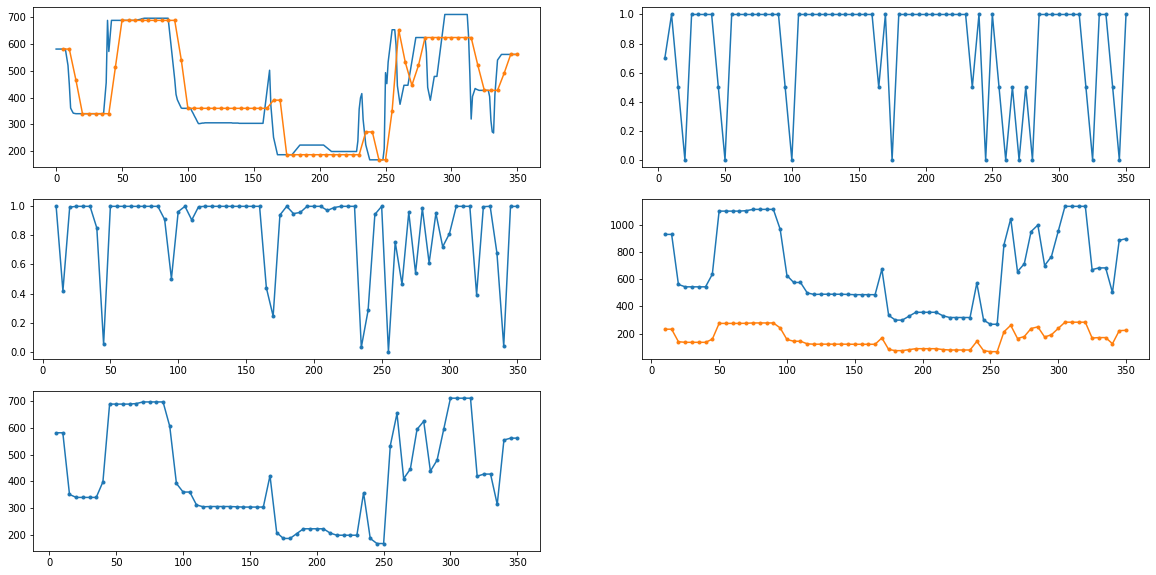

In [210]:
plt.figure(figsize = (20,10))

s = [50,61,41,62,35,58,66,50,51,51,52,50,61,41,62,35,58,66,50,51,51,52,80,130,150,170,
    200,200,201,202,210,200,200,600,600,400,350,
    200,200,201,202,210,200,200,201,202,210,200,200,201,202,201,202,210,200,200,201,202] 
s = readFromRecord('room.txt')   # _special  # night daywalk daybike room cloudy


plt.subplot(3,2,1)
plt.plot(s)

result, res_idx, Gauss_list, gs_high, gs_low, mean_list, a_list, std_list = Gauss2(s, 0.7, 5, False)  
plt.plot(res_idx, result, marker='.')
plt.subplot(3,2,3)
plt.plot(res_idx[1:], Gauss_list, marker='.')

plt.subplot(3,2,4)
plt.plot(res_idx[1:], gs_high, marker='.')
plt.plot(res_idx[1:], gs_low, marker='.')

plt.subplot(3,2,2)
plt.plot(res_idx, a_list, marker='.')

plt.subplot(3,2,5)
plt.plot(res_idx, mean_list, marker='.')

plt.show()

In [ ]:
"""实现高斯分布函数
"""
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range


def normal_distribution(x, mean, sigma):
    return np.exp(-1*((x-mean)**2)/(2*(sigma**2)))/(math.sqrt(2*np.pi)* sigma)

def norm_normal_distribution(x, mean, sigma):
    gs_max = normal_distribution(mean, mean, sigma)
    gs_cur = normal_distribution(x, mean, sigma)
    return gs_cur/gs_max


plt.rcParams['font.sans-serif'] = ['KaiTi']

#写了这个，就不需要plt.show()
x = np.linspace(-50, 50, 300)
### 代码开始 ### (≈ 5~10 行代码)
y_1 = norm_normal_distribution(x, 0, 10)
# y_2 = norm_normal_distribution(x, 3, 10)

plt.figure(figsize=(8,5))#控制画布的大小
plt.plot(x, y_1, c='r') #, label="u=0, d=1"
# plt.plot(x, y_2, c='g') #, label="u=0, d=1"

plt.show()